In [80]:
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
class program():
    def __init__(self, code):
        self.pos = 0 # position pointer
        self.code = defaultdict(lambda:0)
        for i,v in enumerate(code):
            self.code[i] = v
        self.rel = 0 # offset value for relative mode
        self.inputs = []
        
    def add_inputs(self,inputs):
        for i in inputs:
            self.inputs.insert(0,i)
    
    def run(self):
        exit_code = 0
        outputs = []
        while exit_code == 0:
            exit_code, output = self._step()
            if output is not None:
                outputs.append(output)
        return exit_code, outputs
    
    def _parse_opcode(self, opcode):
        """
        Parse an opcode, getting the parameter modes and instruction.
        Opcode should be input as integer.
        """
        code = str(opcode)
        l = len(code)
        inst = int(code[-2:])
        modes = []
        for i in range(l-2):
            modes.append(int(code[l-3-i]))
        return inst, modes
    
    def _get_val_idx(self,loc,mode):
        if mode==0: # position mode
            return self.code[loc]
        elif mode==1: # immediate mode
            return loc
        elif mode==2: # relative mode
            return self.rel+self.code[loc]
        
    def _step(self):
        """
        Exit codes: 
           0 : continue execution
           1 : program finished
           2 : waiting for input
        """
        output = None
        exit_code = 0
        pos = self.pos # where are we in the code

        inst, modes = self._parse_opcode(code[pos])
        if inst == 99: # terminate
            exit_code = 1
            
        if inst == 1: # add
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            self.code[self._get_val_idx(pos+3,modes[2])] = v1+v2 
            pos += 4
            
        if inst == 2: # multiply
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            self.code[self._get_val_idx(pos+3,modes[2])] = v1*v2 
            pos += 4
            
        if inst == 3: # store input
            try:
                modes = modes + (1-len(modes))*[0]
                self.code[self._get_val_idx(pos+1,modes[0])] = self.inputs.pop()
                pos += 2
            except IndexError: # must wait for additional input
                exit_code = 2
                
        if inst == 4: # output value
            modes = modes+(1-len(modes))*[0]
            v = self.code[self._get_val_idx(pos+1,modes[0])]
            output = v
            pos += 2
            
        if inst == 5: # jump-if-true
            modes = modes+(2-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 > 0:
                pos = v2
            else:
                pos += 3
                
        if inst == 6: # jump-if-false
            modes = modes+(2-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 == 0:
                pos = v2
            else:
                pos += 3
                
        if inst == 7:
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 < v2:
                self.code[self._get_val_idx(pos+3,modes[2])] = 1
            else:
                self.code[self._get_val_idx(pos+3,modes[2])] = 0
            pos += 4
            
        if inst == 8:
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 == v2:
                self.code[self._get_val_idx(pos+3,modes[2])] = 1
            else:
                self.code[self._get_val_idx(pos+3,modes[2])] = 0
            pos += 4
            
        if inst == 9: # adjust rel
            modes = modes+(1-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            self.rel += v1
            pos += 2
        self.pos = pos
        return exit_code, output

In [126]:
class robot():
    def __init__(self,code,h,w):
        self.canvas = np.zeros((h,w,2),dtype=np.int)
        self.pos = (int(h/2),int(w/2))
        self.dir = 0
        self.prog = program(code)
        
    def _advance(self,move):
        if move == 0:
            self.dir = (self.dir-1)%4
        else:
            self.dir = (self.dir+1)%4
            
        if self.dir == 0: # move up
            self.pos = (self.pos[0]-1,self.pos[1])
        elif self.dir == 1: # move right 
            self.pos = (self.pos[0],self.pos[1]+1)
        elif self.dir == 2: # move down
            self.pos = (self.pos[0]+1,self.pos[1])
        else: # move left
            self.pos = (self.pos[0],self.pos[1]-1)
            
        if self.pos[0] < 0 or self.pos[0] >= self.canvas.shape[0] or self.pos[1] < 0 or self.pos[1] >= self.canvas.shape[1]:
            self._expand_canvas()
        
    def _expand_canvas(self):
        """
        Expand the size of the canvas by factor of 9, update pos.
        """
        r,c,d = self.canvas.shape
        new_canvas = np.zeros((3*r,3*c,d),dtype=np.int)
        new_canvas[r:2*r,c:2*c,:] = self.canvas
        self.canvas = new_canvas
        self.pos = (self.pos[0]+r,self.pos[1]+c)
        
    def paint(self):
        """
        Perform a painting step, feeding in the current panel color to the program,
        getting the output and acting accordingly.
        """
        out_flag = 0                
        while out_flag != 1:
            self.prog.add_inputs([self.canvas[self.pos[0],self.pos[1],0]])
            out_flag = 0 # reset output flag
            outputs = [] # reset output list
            while out_flag == 0: # run the program until it needs input or finishes
                out_flag, output = self.prog._step()
                if output is not None:
                    outputs.append(output)
            if len(outputs) == 2: # if we got 2 outputs, act
                self.canvas[self.pos[0],self.pos[1],0] = outputs[0]
                self.canvas[self.pos[0],self.pos[1],1] = 1
                self._advance(outputs[1])
def trim_canvas(can):
    """
    The input array has many zeros on the border.
    Trim those away.
    """
    pos_support = np.where(can>0)
    min_r = pos_support[0].min()
    max_r = pos_support[0].max()
    min_c = pos_support[1].min()
    max_c = pos_support[1].max()
    return can[min_r:max_r+1,min_c:max_c+1]            

In [119]:
with open("p11_input.txt","r") as f:
    code = [int(c) for c in f.readline().strip().split(",")]
r = robot(code,200,200)
r.paint()
print("Part 1 answer: {}".format(r.canvas[:,:,1].sum()))

Part 1 answer: 2883


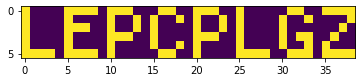

In [127]:
r = robot(code,8,8)
r.canvas[r.pos[0],r.pos[1],0] = 1
r.paint()
plt.imshow(trim_canvas(r.canvas[:,:,0]))
plt.show()